In [1]:
import morphanalysis

In [2]:
# input the path to individual group folders (place them in SMorph)
groups_folders=["Datasets/CTRLvsSTAB/control", "Datasets/CTRLvsSTAB/stab"] 

In [3]:
# color to be used for each group
color_dict={0:'black', 1:'red'}

# group labels
label={0:'control', 1:'stab'}

# marker for each group to be used in PCA plot
marker={0:'*', 1:'o'}

Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 1_GFAP_RIGHT_CA1 _CONTRA_1-2_2.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 1_GFAP_RIGHT_CA1 _CONTRA_1-2_3.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 1_GFAP_RIGHT_CA1 _CONTRA_1-2_4.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 1_GFAP_RIGHT_CA1 _CONTRA_1-2_5.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 1_GFAP_RIGHT_CA1 _CONTRA_1-2_6.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 1_GFAP_RIGHT_CA1 _CONTRA_1-2_7.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 2_GFAP_RIGHT_CA1 _CONTRA_1-2_1.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 2_GFAP_RIGHT_CA1 _CONTRA_1-2_2.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 2_GFAP_RIGHT_CA1 _CONTRA_1-2_3.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 2_GFAP_RIGHT_CA1 _CONTRA_1-2_4.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 2_GFAP_RIGHT_CA1 _CONTRA_1-2_5.tif
Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 2_GFAP_RIGHT_CA1 _CONTRA_1-2_6.tif
Datasets/CTRLvsSTAB/control/

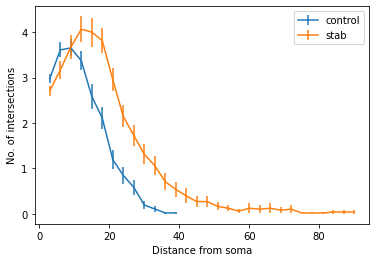

In [4]:
cells = morphanalysis.analyze_cells(groups_folders, 'confocal', label, save_features=True, 
                        show_sholl_plot=True, shell_step_size=3)

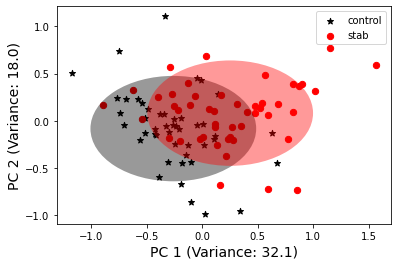

((array([ 3,  6,  9, 12, 15]), array([3, 5, 5, 3, 0], dtype=int64)),
 (array([3, 6, 9]), array([3, 5, 5], dtype=int64)))

In [5]:
cells.pca(3, color_dict, marker)
cells.sholl_original_plots[0], cells.sholl_polynomial_plots[0]

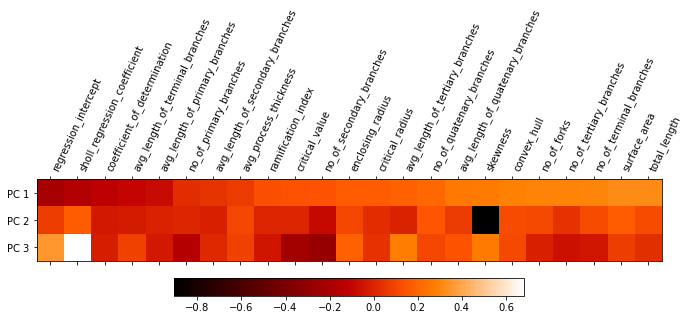

In [6]:
cells.plot_feature_significance_heatmap()

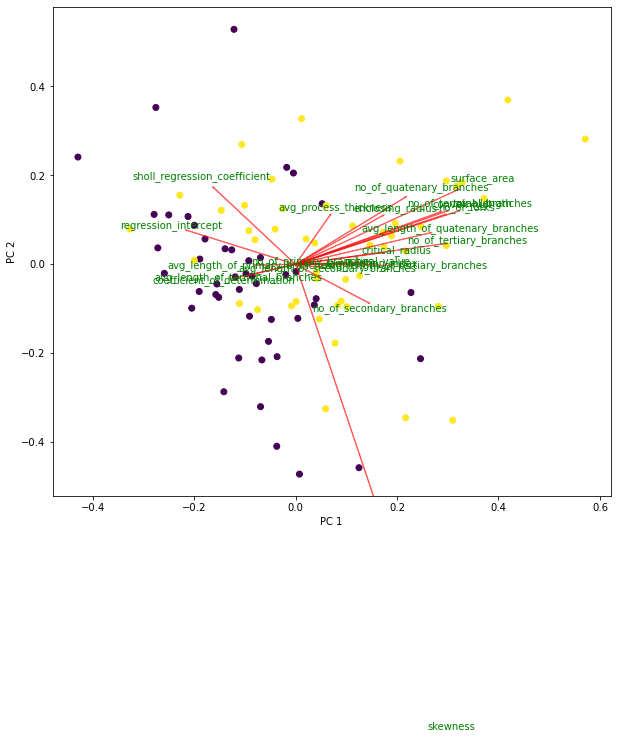

In [7]:
cells.plot_feature_significance_vectors()

In [8]:
cluster_centers, clustered_data = cells.get_clusters(None, False, 3, 'scatter')

k = 4 clusters with Variance Ratio = 45.418890700475934
seed = 90
Using principal components


## Individual histograms

In [9]:
import numpy as np
import matplotlib.pyplot as plt

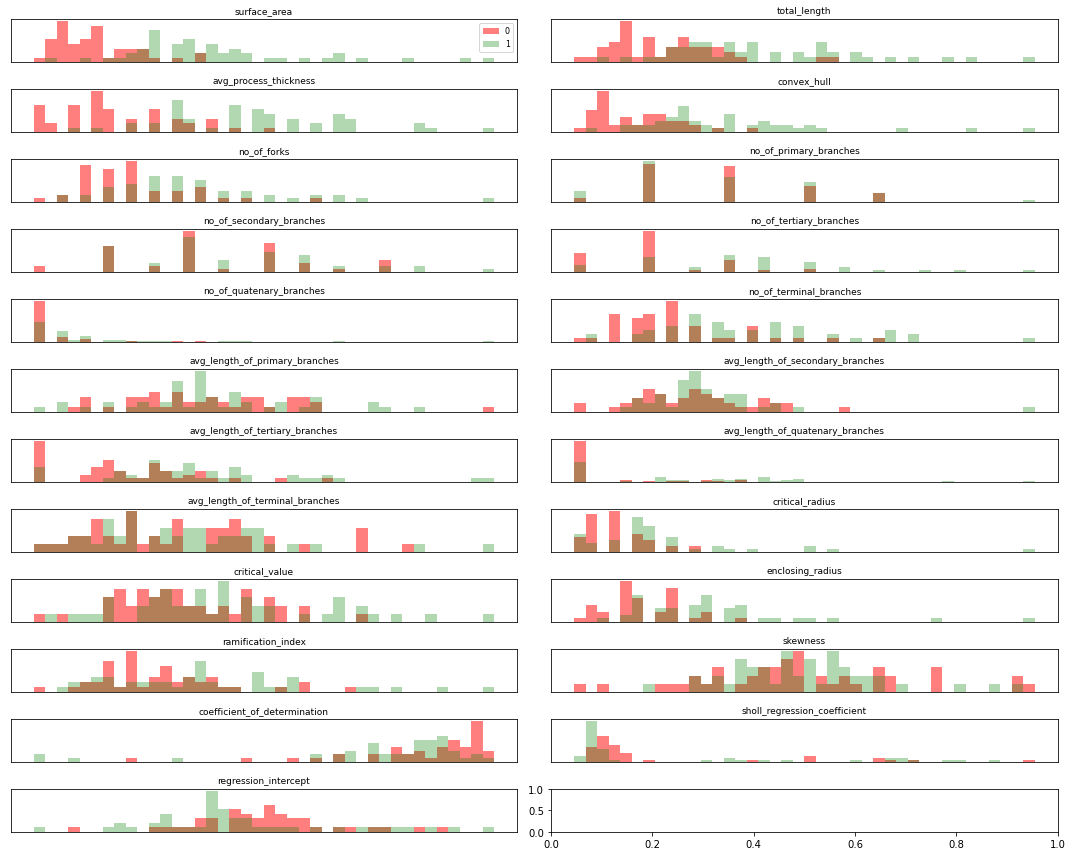

In [10]:
cells.plot_feature_histograms()